In [425]:
from helper_funcs import *
import pickle

# Colourblind friendly colours
import tol_colors as tc
cset = tc.tol_cset('bright')
plt.rc('axes', prop_cycle=plt.cycler('color', list(cset)))

fsize = 24
plt.rcParams.update({'font.size': fsize})


dynamics_path = '../publication/dynamics/'
static_path = '../publication/static_tests/'

tmap = {
    'npt_000conEC_298K':'EMC (298$\,$K)',
    'npt_033conEC_298K':'EC:EMC (3:7) (298$\,$K)',
    'npt_066conEC_298K':'EC:EMC (7:3) (298$\,$K)',
    'npt_100conEC_313K':'EC (313$\,$K)',
    'npt_000conEC_300K':'EMC (300$\,$K)',
    'npt_033conEC_300K':'EC:EMC (3:7) (300$\,$K)',
    'npt_066conEC_300K':'EC:EMC (7:3) (300$\,$K)',
    'npt_100conEC_300K':'EC (300$\,$K)',
}

conmap = {
    '000conEC':'EMC (298$\,$K)',
    '033conEC':'EC:EMC (3:7) (298$\,$K)',
    '066conEC':'EC:EMC (7:3) (298$\,$K)',
    '100conEC':'EC (313$\,$K)',
}

tmap = {
    'npt_000conEC_298K':'EMC',
    'npt_033conEC_298K':'EC:EMC',
    'npt_066conEC_298K':'EC:EMC (7:3)',
    'npt_100conEC_313K':'EC',
    'npt_000conEC_300K':'EMC',
    'npt_033conEC_300K':'EC:EMC (3:7)',
    'npt_066conEC_300K':'EC:EMC (7:3)',
    'npt_100conEC_300K':'EC',
}

conmap = {
    '000conEC':'EMC',
    '033conEC':'EC:EMC (3:7)',
    '066conEC':'EC:EMC (7:3)',
    '100conEC':'EC',
}

In [426]:
import pickle

def get_mol_positions(atoms):
	positions = []
	mol_set = set(atoms.arrays['molID'])
	for ID in mol_set:
		mol = atoms[atoms.arrays['molID'] == ID]
		com = mol.get_center_of_mass()
		positions.append(com)
	positions = np.array(positions)
	return positions#, len(mol_set)

def mol_rdf(atoms, rmax, nbins, return_num_mols=False):
	positions = get_mol_positions(atoms)
	nmols, dim = positions.shape
	box_length = atoms.get_volume()**(1/3)
	for i, p in enumerate(positions):
		# PBC
		delta = positions[i+1:]-positions[i]
		delta -= box_length*np.round(delta/box_length)
		
		# Get counts
		dists = np.linalg.norm(delta, axis=1)
		s = sorted(dists[dists <= rmax])[1:]
		if i == 0:
			counts, bins = np.histogram(s, nbins, (0,rmax))
		else:
			counts += np.histogram(s, nbins, (0,rmax))[0]

	if return_num_mols:
		return counts, bins, nmols
	else:
		return counts, bins

def compute_rdf(traj, rmax=None, nbins=100, return_rho=False):
	for i, atoms in enumerate(traj):
		if i == 0:
			counts, bins, nmols = mol_rdf(atoms, rmax=rmax, nbins=nbins, return_num_mols=True)
			volume = atoms.get_volume()
			box_length = volume**(1/3)
			r = 0.5*(bins[1:]+bins[:-1])
		else:
			counts += mol_rdf(atoms, rmax=rmax, nbins=nbins)[0]
	
	num_snapshots = i+1
	nvalid = nmols/2
	n_k = counts/(nvalid*num_snapshots)	
	dr = rmax/nbins
	shell_volumes = 4/3*np.pi*((r+dr)**3-r**3)
	rho = nmols/volume
	
	g = n_k/(rho*shell_volumes)
	if return_rho:
		return g, r, rho
	else:
		return g, r

def get_indices_of_sign_change(lst):
    arr = np.array(lst)
    sign_changes = np.where(np.diff(np.sign(arr)) != 0)[0]
    #sign_changes = sign_changes[sign_changes>55] # The limit was taken from observation
    return sign_changes



def eval_rdfs(tags, traj_path, slice=':'):
    rdfs = {}
    number_densities = {}
    for tag in tags:
        data_set, functional, seed, dset_sample = tag.split('/')
        flist = [name for name in glob.glob(f'{traj_path}{tag}/*') if '.xyz' in name]
        name = f'{data_set}_{functional}'
        print(name, dset_sample, seed)

        for file in flist:
            print(file)
            comp = file.split('/')[-1].split('.')[0][4:-5]
            comp = conmap[comp]
            traj = read(file, slice)
            aa.find_molecs(traj, fct=1.0)
            g, r, rho = compute_rdf(traj, rmax=11, return_rho=True)

            if name not in rdfs:
                rdfs[name] = {}
            if dset_sample not in rdfs[name]:
                rdfs[name][dset_sample] = {}
            if seed not in rdfs[name][dset_sample]:
                rdfs[name][dset_sample][seed] = {}
            
            if name not in number_densities:
                number_densities[name] = {}
            if dset_sample not in number_densities[name]:
                number_densities[name][dset_sample] = {}
            if seed not in number_densities[name][dset_sample]:
                number_densities[name][dset_sample][seed] = {}

            rdfs[name][dset_sample][seed][comp] = [g, r]
            number_densities[name][dset_sample][seed][comp] = rho
            del traj
    
    return rdfs, number_densities

def get_start_index(time, msd, threshold, window=10, start_id=0):
    window = int(window)
    start_id = int(start_id)
    print(f'Using slope error thresold of: {threshold}')
    #time = time
    for i, t in enumerate(time[start_id:]):
        if i > window:
            
            slope, intercept, err, r2 = get_slope(np.log(time[i:i+window]),np.log(msd[i:i+window]))
            if abs(slope-1) < threshold:
                idx = start_id+i
                break
            else:
                idx = None
    
    return idx, r2

def get_colour(name):
    import tol_colors as tc
    cset = tc.tol_cset('bright')

    colmap = {
        'EMC (298$\,$K)':'blue',
        'EMC (300$\,$K)':'blue',
        'EC:EMC (3:7) (298$\,$K)':'green',
        'EC:EMC (3:7) (300$\,$K)':'green',
        'EC:EMC (7:3) (298$\,$K)':'yellow',
        'EC:EMC (7:3) (300$\,$K)':'yellow',
        'EC (313$\,$K)':'red',
        'EC (300$\,$K)':'red',
    }

    tmap = {
        'npt_000conEC_298K':'EMC (298$\,$K)',
        'npt_033conEC_298K':'EC:EMC (3:7) (298$\,$K)',
        'npt_066conEC_298K':'EC:EMC (7:3) (298$\,$K)',
        'npt_100conEC_313K':'EC (313$\,$K)',
        'npt_000conEC_300K':'EMC (300$\,$K)',
        'npt_033conEC_300K':'EC:EMC (3:7) (300$\,$K)',
        'npt_066conEC_300K':'EC:EMC (7:3) (300$\,$K)',
        'npt_100conEC_300K':'EC (300$\,$K)',
    }
    try:
        return getattr(cset, colmap[name])
    except:
        return getattr(cset, colmap[tmap[name]])

# Training error
Currently missing GAP resutls!

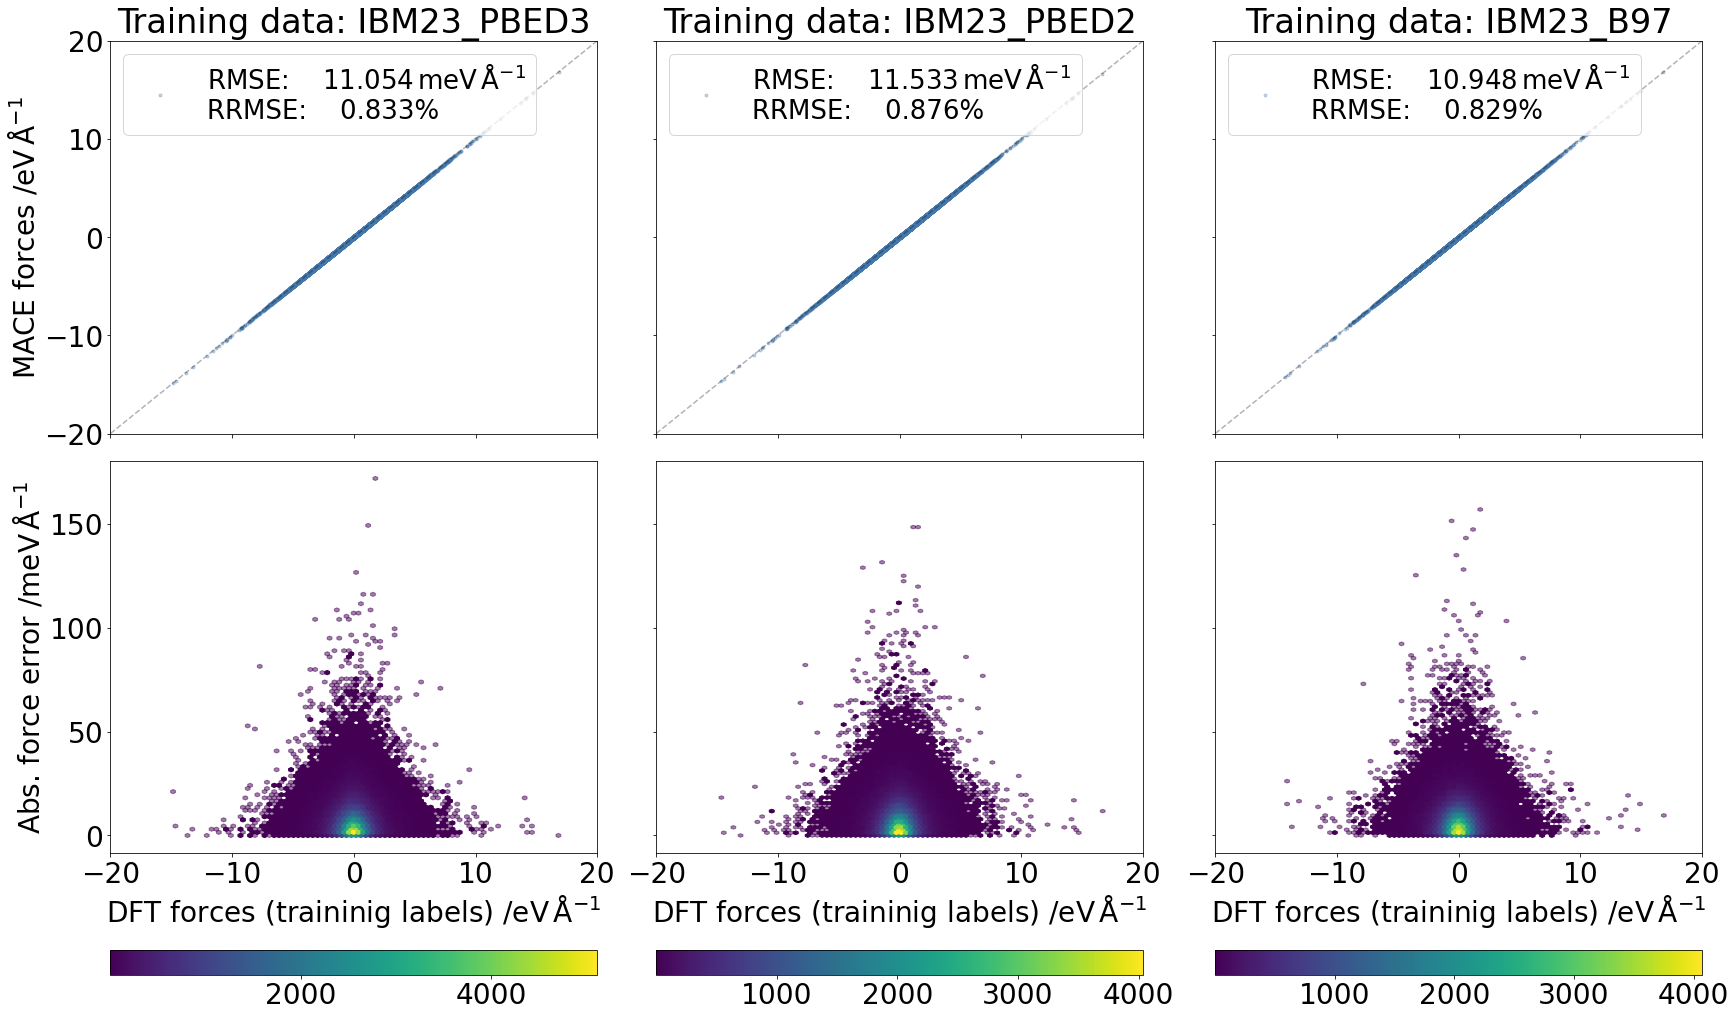

In [ ]:
tags = [
    'IBM23/PBED3/SEED1/DSET1',
    'IBM23/PBED2/SEED1/DSET1',
    'IBM23/B97/SEED1/DSET1',
] # These tags needs to be adjusted to be compliant with zenodo

# Obtain data and store to dicts
xyz = dict()
for tag in tags:
    xyz[tag] = get_xyz(f'{static_path}/{tag}/*') # Argument should be 'tag' to be consistent with zenodo


fig, axs = plt.subplots(2,len(tags), figsize=(8*len(tags), 7*2), sharex=True, sharey='row', layout='constrained')
for i, k in enumerate(xyz):
    tag = tags[i]
    atoms = xyz[k]
    data_set, functional, seed, dset_sample = tag.split('/')
    
    # Obtain forces and errors
    ## reference
    ref_forces = [a.arrays['forces'] for a in atoms if 'forces' in a.arrays.keys()]
    ref_forces = np.concatenate(ref_forces).flatten()

    ## mace
    mace_forces = [a.arrays['MACE_forces'] for a in atoms if 'forces' in a.arrays.keys()]
    mace_forces = np.concatenate(mace_forces).flatten()
    rmse, rrmse = RMSE(ref_forces, mace_forces)

    # Plot correlations
    axs[0,i].set_title(f'Training data: {data_set}_{functional}')
    axs[0,i].plot(ref_forces, mace_forces, '.', label=f'RMSE:    {rmse*1e3:.3f}$\\,$meV$\,$Å$^{{-1}}$\nRRMSE:    {rrmse*100:.3f}%', alpha=0.3)
    axs[0,i].legend(loc='upper left', numpoints=1, fontsize=fsize-2)

    # Plot settings
    axs[0,i].plot([0, 1], [0, 1], 'k--', transform=axs[0,i].transAxes, alpha=0.3)
    axs[0,i].set_xlim([-20,20])
    axs[0,i].set_ylim([-20,20])
    if i == 0: axs[0,i].set_ylabel('MACE forces /eV$\,$Å$^{-1}$')

    #if i == 0:
    #    h = axs[1,i].hexbin(ref_forces, abs(ref_forces-mace_forces)*1000, mincnt=1)
    #else:
    #    axs[1,i].hexbin(ref_forces, abs(ref_forces-mace_forces)*1000, mincnt=1)
    #h = axs[1,i].hexbin(ref_forces, abs(ref_forces-mace_forces)*1000, mincnt=1)
    h = axs[1,i].hexbin(ref_forces, abs(ref_forces-mace_forces)*1000, mincnt=1, alpha=0.5)
    h = axs[1,i].hexbin(ref_forces, abs(ref_forces-mace_forces)*1000, mincnt=2)
    plt.colorbar(h, ax=axs[1,i], orientation='horizontal')
    axs[1,i].set_xlabel('DFT forces (traininig labels) /eV$\,$Å$^{-1}$')
    axs[1,0].set_ylabel('Abs. force error /meV$\,$Å$^{-1}$')
    
#plt.colorbar(h, ax=axs[-1,-1])
#plt.tight_layout()

## A perspective on force errors
1. Calculate the average movement of an atom during a time step
2. Integrate the force along that distance to get the potential error in terms of an energy
3. Plot the correlation and determine the RMSE of this energy

In [ ]:
tags = [
    'IBM23/PBED3/SEED1/DSET1',
    'IBM23/PBED2/SEED1/DSET1',
    'IBM23/B97/SEED1/DSET1',
] # These tags needs to be adjusted to be compliant with zenodo

xyz = dict()
for tag in tags:
    xyz[tag] = get_all_thermo(f'{dynamics_path}{tag}/*', xyz=True) # Argument should be 'tag' to be consistent with zenodo

In [ ]:
step_lengths = []
for tag, thermo_dict in xyz.items():
    for config, traj in thermo_dict.items():
        x = [a.positions for a in traj]
        dxdt = np.concatenate([dx/10 for dx in np.diff(x)])
        step_lengths.append(np.mean(dxdt))

#print(step_lengths)
avg_step_length = np.mean(np.abs(step_lengths))
#print(avg_step_length)
print(f'Avg. step length per atom per time step: {avg_step_length:.5f}')

Avg. step length per atom per time step: 0.02524


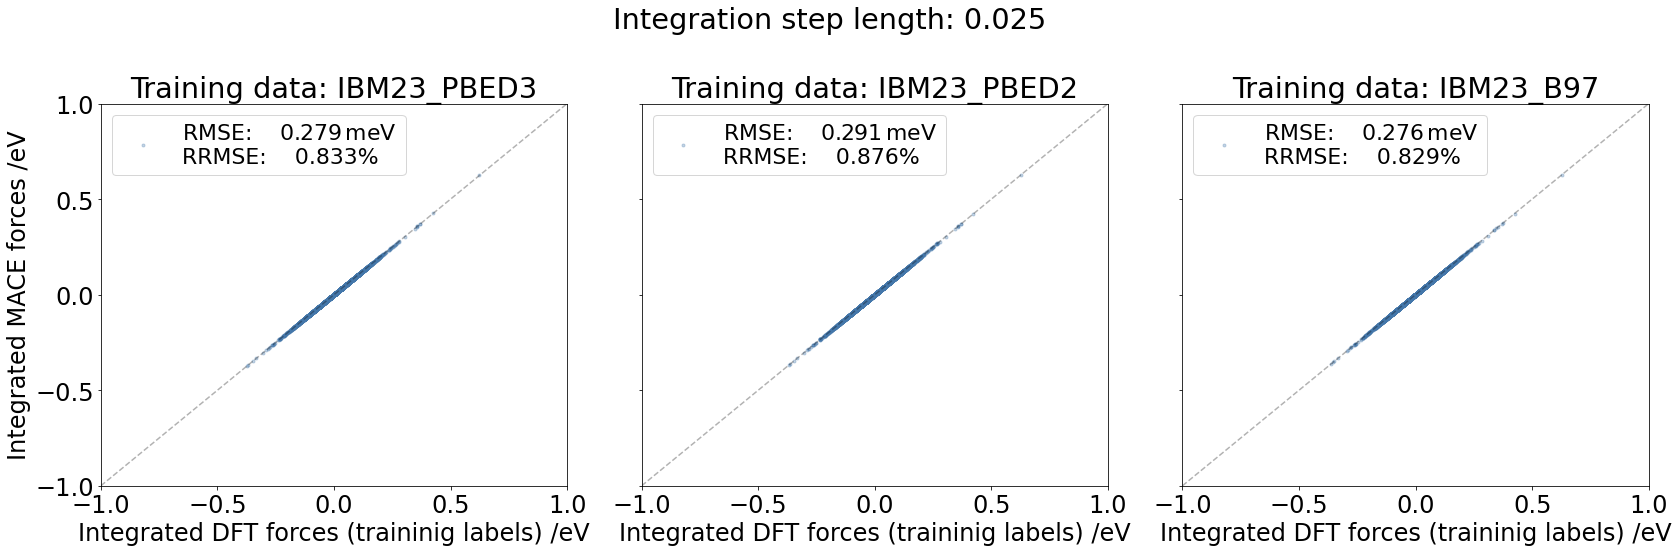

In [ ]:
step_length = 0.02524

# Obtain data and store to dicts
xyz = dict()
for tag in tags:
    xyz[tag] = get_xyz(f'{static_path}/{tag}/*') # Argument should be 'tag' to be consistent with zenodo


fig, axs = plt.subplots(1,len(tags), figsize=(8*len(tags), 8*1), sharex=True, sharey=True)
for i, k in enumerate(xyz):
    tag = tags[i]
    atoms = xyz[k]
    data_set, functional, seed, dset_sample = tag.split('/')
    
    # Obtain forces and errors
    ## reference
    ref_forces = [a.arrays['forces']*step_length for a in atoms if 'forces' in a.arrays.keys()]
    ref_forces = np.concatenate(ref_forces).flatten()

    ## mace
    mace_forces = [a.arrays['MACE_forces']*step_length for a in atoms if 'forces' in a.arrays.keys()]
    mace_forces = np.concatenate(mace_forces).flatten()
    rmse, rrmse = RMSE(ref_forces, mace_forces)

    # Plot correlations
    axs[i].set_title(f'Training data: {data_set}_{functional}')
    axs[i].plot(ref_forces, mace_forces, '.', label=f'RMSE:    {rmse*1e3:.3f}$\\,$meV\nRRMSE:    {rrmse*100:.3f}%', alpha=0.3)
    axs[i].legend(loc='upper left', numpoints=1, fontsize=fsize-2)

    # Plot settings
    axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.3)
    axs[i].set_xlabel('Integrated DFT forces (traininig labels) /eV')
    axs[i].set_xlim([-1,1])
    axs[i].set_ylim([-1,1])
    if i == 0: axs[i].set_ylabel('Integrated MACE forces /eV')

fig.suptitle(f'Integration step length: {step_length:.3f}')    
plt.tight_layout()

# NPT dynamics

In [501]:
tags = [
    'IBM23/GAP/SEED1/DSET1',
    'IBM23/PBED3/SEED1/DSET1',
    'IBM23/PBED2/SEED1/DSET1',
    'IBM23/B97/SEED1/DSET1',
] # These tags needs to be adjusted to be compliant with zenodo

thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(f'{dynamics_path}{tag}/*', xyz=False) # Argument should be 'tag' to be consistent with zenodo

## Determining diffusion limit start times
### Taken from *Best Practices for Computing Transport Properties 1. Self-Diffusivity and Viscosity from Equilibrium Molecular Dynamics [Article v1.0]*
#### 5.2.3 Data analysis
In order to obtain reliable estimates of D, it is important to consider how the linear regression is performed for the MSD with respect to time (Equation 2). Specifically, the time interval that is included in the regression can have a significant impact on the predicted value of D. We recommend that only the “middle” of the MSD be used in the fit to approximate the long-time slope. Short time must be excluded as it follows a ballistic trajectory, while very long time is excluded due to the increased noise. **Currently, we are unaware of an objective approach for defining the “middle” region. Until such an approach exists, we recommend that the author reports how the region was selected and how much variability in D can be attributed to the choice of this region**. In addition, the uncertainty in the fit of the slope should be reported.

A typical log-log plot, borrowed from Ref. [36], is provided in Figure 2, where the linear regression to the “middle” region is included. From visual inspection, the “ballistic” short-time interval ranges from the beginning of the simulation to approximately 100 ps. **The “middle” region is identified by the linear regime with a slope of 1 (for a log-log plot)** spanning from approximately 100 ps to 1000 ps. Note that the noisy “long-time” simulation data (beyond 1000 ps) are not depicted in Figure 2 and are excluded from the linear fit.

In [502]:
diff_coeffs = []
diff_errs = []
log_r2 = []
diff_r2 = []
diff_starts = []
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for j, (traj_name, traj_data) in enumerate(thermo[k].items()):

        if functional == 'GAP':
            time, tunit = traj_data['TimeStep']['data'], 'fs'
            msd, munit = traj_data['c_compMSD[4]']['data'], '?'

        else:
            # Collect data
            time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
            msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']
            
        idx, r2 = get_start_index(time,msd,threshold=5e-2, window=2000, start_id=0)
        if idx != None:   
            D, err, R2 = diffusion_coefficient(time[idx:],msd[idx:])
            diff_coeffs.append(D)
            diff_errs.append(err)
            log_r2.append(r2)
            diff_r2.append(R2)
            print(idx, len(time), r2, D, err, R2)
            diff_starts.append(idx)
        else:
            diff_coeffs.append(np.nan)
            diff_errs.append(np.nan)
            log_r2.append(np.nan)
            diff_r2.append(np.nan)
            diff_starts.append(np.nan)

Using slope error thresold of: 0.05
2452 19132 0.9590497559533364 3.52935877826708e-10 2.970917737029497e-12 0.9915281756290308
Using slope error thresold of: 0.05
6677 19262 0.9030769184707952 3.7022578597905766e-10 5.933032109046249e-12 0.9771707066292507
Using slope error thresold of: 0.05
2001 19250 0.9791801290908948 2.836803383346475e-10 2.703122647470774e-12 0.9888046556856378
Using slope error thresold of: 0.05
3727 19341 0.9014876609674487 1.5168215176788236e-10 2.1205568015853112e-12 0.9784152711102528
Using slope error thresold of: 0.05
2195 99999 0.9613629873264623 1.6315787984001455e-09 5.9591169994478986e-12 0.9906543785582791
Using slope error thresold of: 0.05
2348 99999 0.9736607222206628 1.112190361082902e-09 3.148790396252487e-12 0.9943722267949265
Using slope error thresold of: 0.05
2001 99999 0.9397001926172969 9.388300200188796e-10 2.820724909490822e-12 0.9936440960475516
Using slope error thresold of: 0.05
4157 99998 0.9047664286706759 7.049472669710002e-10 3.069

In [ ]:
def get_dens(tags, root_path, std=False):
    thermo = dict()
    for tag in tags:
        thermo[tag] = get_all_thermo(f'{root_path}{tag}/*.thermo')
    
    densities = dict()
    densities_std = dict()
    for i, k in enumerate(thermo):
        tag = tags[i]
        densities[tag] = {}
        densities_std[tag] = {}
        for traj_name, traj_data in thermo[k].items():
            # Collect data
            if 'GAP' in tag:
                dens, dunit = traj_data['v_mdensity']['data'], '?'
            else:
                dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
            #densities[tag]['units'] = dunit
            densities[tag][traj_name] = np.mean(dens)
            densities_std[tag][traj_name] = np.std(dens)
    if std:
        return densities, densities_std, dunit
    else:
        return densities, dunit


def get_density(tags, dynamics_path, std=False):
    conmap = {
        '000conEC':'EMC (298$\,$K)',
        '033conEC':'EC:EMC (3:7) (298$\,$K)',
        '066conEC':'EC:EMC (7:3) (298$\,$K)',
        '100conEC':'EC (313$\,$K)',
    }
    conmap = {
        '000conEC':'EMC',
        '033conEC':'EC:EMC (3:7)',
        '066conEC':'EC:EMC (7:3)',
        '100conEC':'EC',
    }
    
    
    # Compute average densities
    dens = dict()
    if std:
        dens, denstd, dunit = get_dens(tags, dynamics_path, std=True)
    else:
        dens, dunit = get_dens(tags, dynamics_path)
    print(dens)

    # Collect average densities for all tags
    data = {
        'Train data':[],
        'Functional':[],
        'Seed':[],
        'Sample':[],
        'Composition':[],
        'Temperature':[],
        'Avg. density':[],
    }
    if std:
        data |= {'Std. density':[]}

    for tag, d in dens.items():
        data_set, functional, seed, dset_sample = tag.split('/')
        seed = int(seed[-1]); dset_sample = int(dset_sample[-1])

        # Add one instance per composition
        for i in range(4):
            data['Train data'].append(data_set)
            data['Functional'].append(functional)
            data['Seed'].append(seed)
            data['Sample'].append(dset_sample)
        
        # Add average densities for each composition
        for traj_name, avg_dens in d.items():
            
            #print(comp)
            _, comp, temp = traj_name.split('_')
            temp = temp[:-1]
            data['Composition'].append(conmap[comp])
            data['Temperature'].append(temp)
            #data['Composition'].append(tmap[traj_name])
            
            data['Avg. density'].append(avg_dens)
            if std:
                data['Std. density'].append(denstd[tag][traj_name])
    #for key,val in data.items():
    #    print(key, len(val))
    return pd.DataFrame(data), dunit



def get_colour(name):
    import tol_colors as tc
    cset = tc.tol_cset('bright')

    colmap = {
        'EMC':'blue',
        'EC:EMC (3:7)':'green',
        'EC:EMC (7:3)':'yellow',
        'EC':'red',
    }

    tmap = {
        'npt_000conEC_298K':'EMC',
        'npt_033conEC_298K':'EC:EMC (3:7)',
        'npt_066conEC_298K':'EC:EMC (7:3)',
        'npt_100conEC_313K':'EC',
        'npt_000conEC_300K':'EMC',
        'npt_033conEC_300K':'EC:EMC (3:7)',
        'npt_066conEC_300K':'EC:EMC (7:3)',
        'npt_100conEC_300K':'EC',
    }
    try:
        return getattr(cset, colmap[name])
    except:
        return getattr(cset, colmap[tmap[name]])

In [504]:
df, dunit = get_density(tags, dynamics_path, std=True)
df['Diffusion coefficient'] = [d*1e10 for d in diff_coeffs] # 1e-6 cm2/s
#df['Corr. diffusion coefficient'] = [fsize_correction(D,r) for D,r in df[['Diffusion coefficient', 'Avg. density']]]
df['Diff. fit error'] = [e*1e10 for e in diff_errs] # 1e-6 cm2/s
df['log-log r2'] = log_r2
df['Diff. r2'] = diff_r2
df['Diff. start time /ns'] = [time[s]*1e-6 if type(s) == int else np.nan for s in diff_starts]
df.style.map(rvalue_formatting, subset=['log-log r2', 'Diff. r2'])

{'IBM23/GAP/SEED1/DSET1': {'npt_000conEC_300K': 1.0253923356679908, 'npt_033conEC_300K': 1.0669965374831274, 'npt_066conEC_300K': 1.1449518529350649, 'npt_100conEC_300K': 1.2682903682849904}, 'IBM23/PBED3/SEED1/DSET1': {'npt_000conEC_298K': 0.965048030690307, 'npt_033conEC_298K': 1.0407824278542783, 'npt_066conEC_298K': 1.1294808898588986, 'npt_100conEC_313K': 1.2329968122062442}, 'IBM23/PBED2/SEED1/DSET1': {'npt_000conEC_298K': 1.0470562373771215, 'npt_033conEC_298K': 1.1293502533476003, 'npt_066conEC_298K': 1.225466864695941, 'npt_100conEC_313K': 1.3371394257727731}, 'IBM23/B97/SEED1/DSET1': {'npt_000conEC_298K': 1.0894762314769442, 'npt_033conEC_298K': 1.1497529669993403, 'npt_066conEC_298K': 1.222773680913618, 'npt_100conEC_313K': 1.3026712548650974}}


,Train data,Functional,Seed,Sample,Composition,Temperature,Avg. density,Std. density,Diffusion coefficient,Diff. fit error,log-log r2,Diff. r2,Diff. start time /ns
0,IBM23,GAP,1,1,EMC,300,1.025392,0.015684,3.529359,0.029709,0.959050,0.991528,0.024520
1,IBM23,GAP,1,1,EC:EMC (3:7),300,1.066997,0.015544,3.702258,0.059330,0.903077,0.977171,0.066770
2,IBM23,GAP,1,1,EC:EMC (7:3),300,1.144952,0.016677,2.836803,0.027031,0.979180,0.988805,0.020010
3,IBM23,GAP,1,1,EC,300,1.268290,0.014502,1.516822,0.021206,0.901488,0.978415,0.037270
4,IBM23,PBED3,1,1,EMC,298,0.965048,0.016399,16.315788,0.059591,0.961363,0.990654,0.021950
5,IBM23,PBED3,1,1,EC:EMC (3:7),298,1.040782,0.016999,11.121904,0.031488,0.973661,0.994372,0.023480
6,IBM23,PBED3,1,1,EC:EMC (7:3),298,1.129481,0.015671,9.388300,0.028207,0.939700,0.993644,0.020010
7,IBM23,PBED3,1,1,EC,313,1.232997,0.016728,7.049473,0.030697,0.904766,0.987030,0.041570
8,IBM23,PBED2,1,1,EMC,298,1.047056,0.016843,13.423345,0.058850,0.972463,0.986563,0.020010
9,IBM23,PBED2,1,1,EC:EMC (3:7),298,1.129350,0.015385,7.666774,0.024511,0.874274,0.992966,0.041490


## Results

/tmp/ipykernel_2909/1080101142.py:65: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[i].set_ylim([0, 1000])


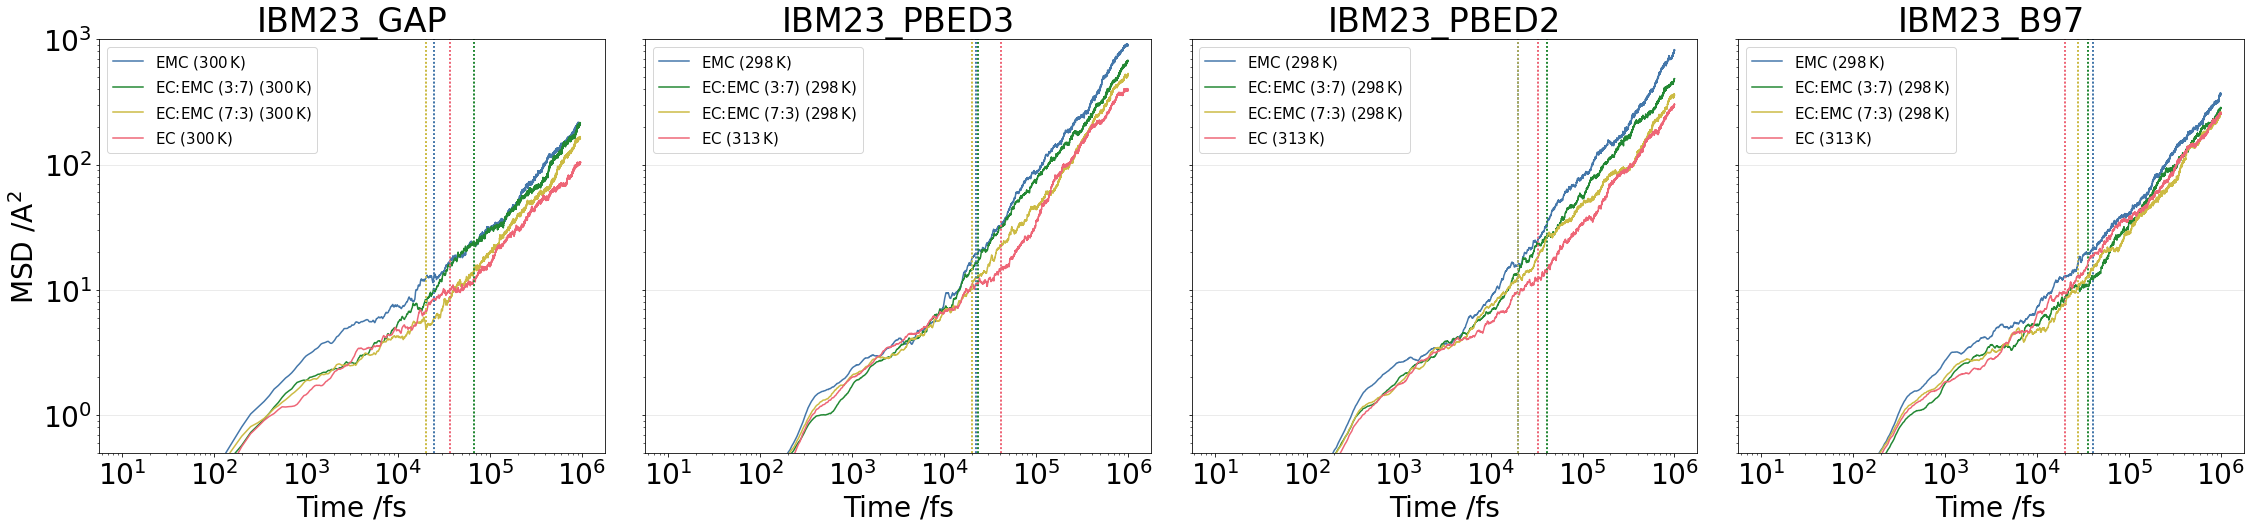

In [413]:
plt.rcParams.update({'font.size': fsize})

order = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]
order = [
    'EMC',
    'EC:EMC (3:7)', 
    'EC:EMC (7:3)',
    'EC',
]

# Pivot tables for plotting
avg_pivot_df = df.pivot(
	index='Functional',
	columns='Composition',
	values='Avg. density',
).sort_index(axis=0,ascending=False)[order]

std_pivot_df = df.pivot(
	index='Functional',
	columns='Composition',
	values='Std. density',
).sort_index(axis=0,ascending=False)[order]


diff_pivot_df = df.pivot(
	index='Functional',
	columns='Composition',
	values='Diffusion coefficient',
	#values=['Avg. density', 'Var.'],
).sort_index(axis=0,ascending=False)[order]

differr_pivot_df = df.pivot(
	index='Functional',
	columns='Composition',
	values='Diff. fit error',
).sort_index(axis=0,ascending=False)[order]


fig, axs = plt.subplots(1,len(tags), figsize=(8*len(tags), 8*1), sharex=True, sharey=True)
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for j, (traj_name, traj_data) in enumerate(thermo[k].items()):
        if functional == 'GAP':
            time, tunit = traj_data['TimeStep']['data'], 'fs'
            dens, dunit = traj_data['v_mdensity']['data'], '?'
            msd, munit = traj_data['c_compMSD[4]']['data'], 'Å^2'

        else:
            # Collect data
            time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
            dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
            msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']

        # Plot density
        axs[i].set_ylim([0.5, 1.4])
        

        # Plot MSD
        axs[i].set_ylim([0, 1000])
        axs[0].set_ylabel(f'MSD /{munit}')
        axs[i].plot(time,msd, label=tmap[traj_name], color=get_colour(traj_name))

        axs[i].set_xscale('log')
        axs[i].set_yscale('log')

        axs[0].axvline(df['Diff. start time /ns'].iloc[j]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        axs[1].axvline(df['Diff. start time /ns'].iloc[j+4]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        axs[2].axvline(df['Diff. start time /ns'].iloc[j+8]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        axs[3].axvline(df['Diff. start time /ns'].iloc[j+12]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')

        # Shared plot setings
        axs[i].set_title(f'{data_set}_{functional}')
        axs[i].set_xlabel(f'Time /{tunit}')
        axs[i].grid(axis='y', alpha=0.3)
        

    axs[i].legend(loc='upper left', fontsize=15)


plt.tight_layout()

In [414]:
plot_df = df.drop('Seed', axis=1)
plot_df = plot_df.drop('Sample', axis=1)
plot_df

,Train data,Functional,Composition,Temperature,Avg. density,Std. density,Diffusion coefficient,Diff. fit error,log-log r2,Diff. r2,Diff. start time /ns
0,IBM23,GAP,EMC,300,1.025392,0.015684,3.529359,0.029709,0.959050,0.991528,0.02452
1,IBM23,GAP,EC:EMC (3:7),300,1.066997,0.015544,3.702258,0.059330,0.903077,0.977171,0.06677
2,IBM23,GAP,EC:EMC (7:3),300,1.144952,0.016677,2.836803,0.027031,0.979180,0.988805,0.02001
3,IBM23,GAP,EC,300,1.268290,0.014502,1.516822,0.021206,0.901488,0.978415,0.03727
4,IBM23,PBED3,EMC,298,0.965048,0.016399,16.315788,0.059591,0.961363,0.990654,0.02195
5,IBM23,PBED3,EC:EMC (3:7),298,1.040782,0.016999,11.121904,0.031488,0.973661,0.994372,0.02348
6,IBM23,PBED3,EC:EMC (7:3),298,1.129481,0.015671,9.388300,0.028207,0.939700,0.993644,0.02001
7,IBM23,PBED3,EC,313,1.232997,0.016728,7.049473,0.030697,0.904766,0.987030,0.04157
8,IBM23,PBED2,EMC,298,1.047056,0.016843,13.423345,0.058850,0.972463,0.986563,0.02001
9,IBM23,PBED2,EC:EMC (3:7),298,1.129350,0.015385,7.666774,0.024511,0.874274,0.992966,0.04149


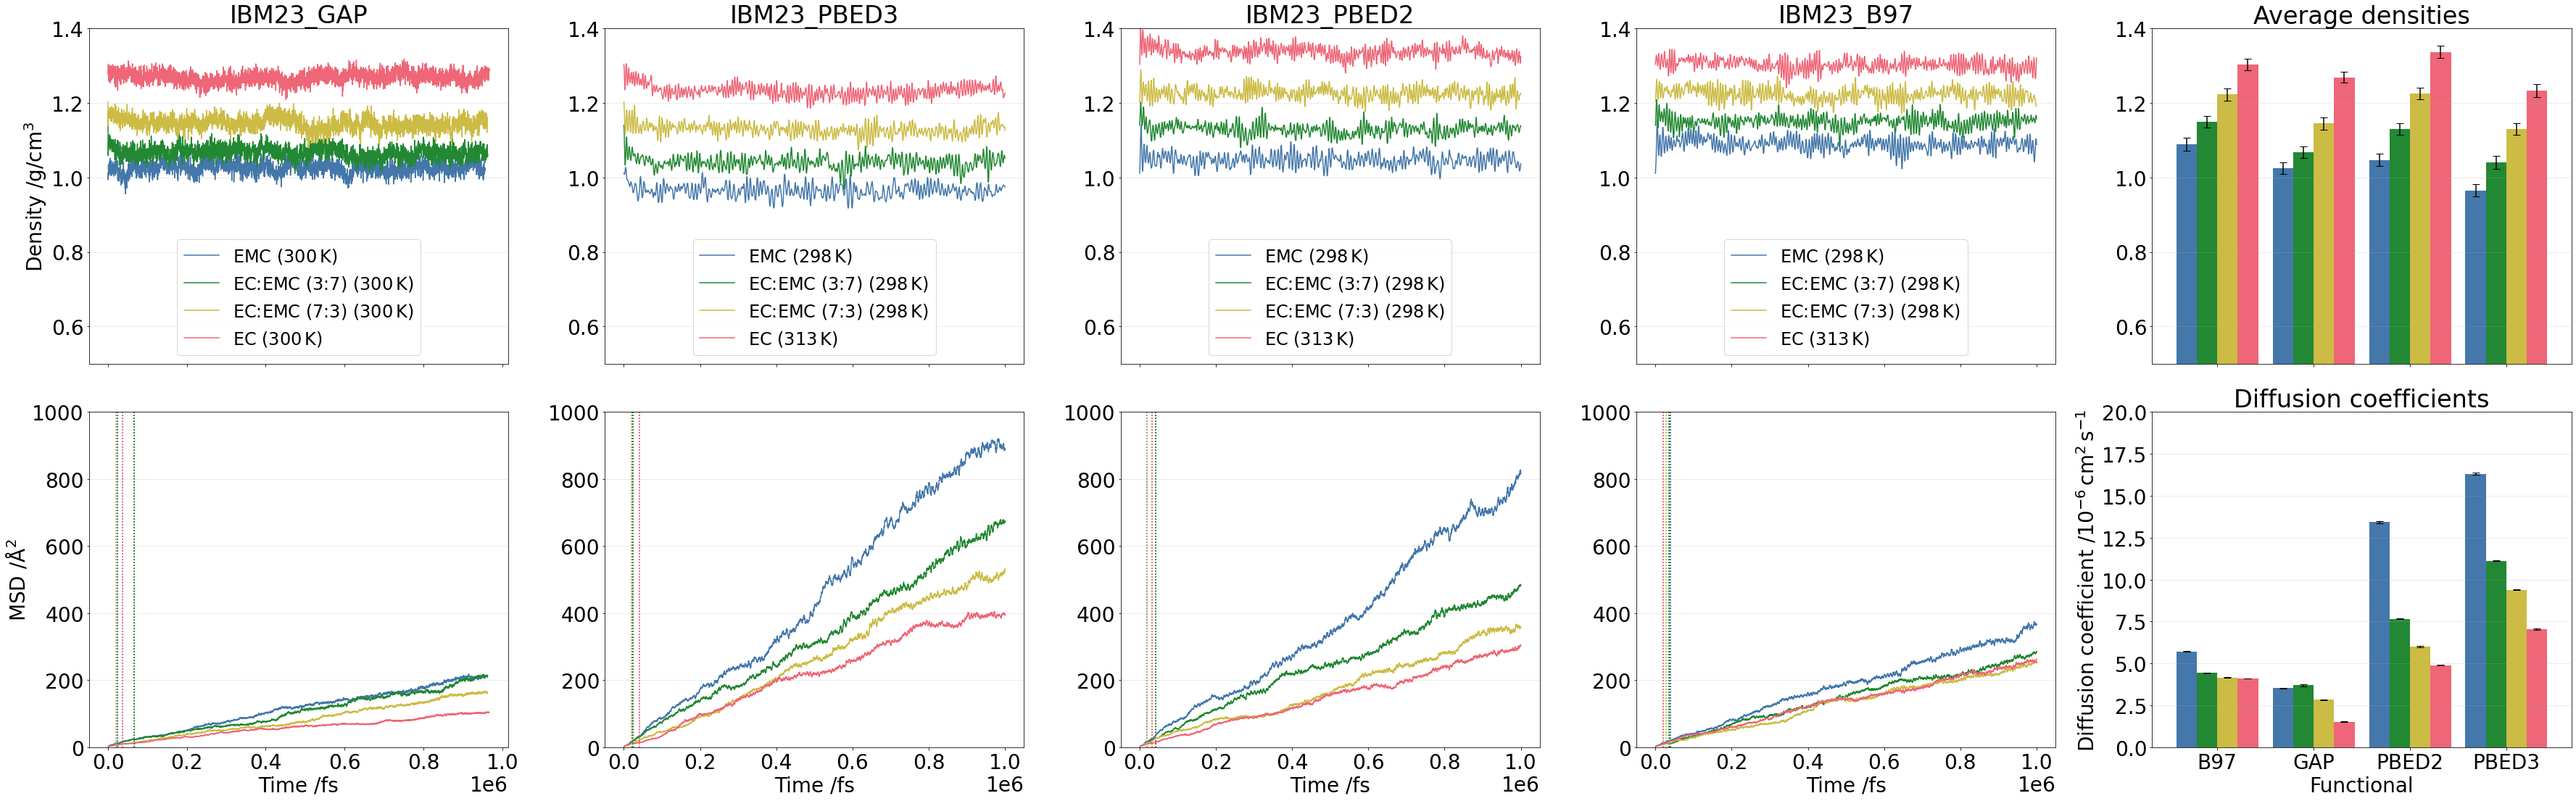

In [415]:
fsize = 28
plt.rcParams.update({'font.size': fsize})

order = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]
order = [
    'EMC',
    'EC:EMC (3:7)', 
    'EC:EMC (7:3)',
    'EC',
]

# Pivot tables for plotting
avg_pivot_df = plot_df.pivot(
	index='Functional',
	columns='Composition',
	values='Avg. density',
).sort_index(axis=0,ascending=True)[order]

std_pivot_df = plot_df.pivot(
	index='Functional',
	columns='Composition',
	values='Std. density',
).sort_index(axis=0,ascending=True)[order]

diff_pivot_df = plot_df.pivot(
	index='Functional',
	columns='Composition',
	values='Diffusion coefficient',
).sort_index(axis=0,ascending=True)[order]

differr_pivot_df = df.pivot(
	index='Functional',
	columns='Composition',
	values='Diff. fit error',
).sort_index(axis=0,ascending=True)[order]


fig, axs = plt.subplots(2,len(tags)+1, figsize=(10*(len(tags)+1), 8*2), sharex='col')
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for j, (traj_name, traj_data) in enumerate(thermo[k].items()):

        if functional == 'GAP':
            time, tunit = traj_data['TimeStep']['data'], 'fs'
            dens, dunit = traj_data['v_mdensity']['data'], 'g/cm$^3$'
            msd, munit = traj_data['c_compMSD[4]']['data'], 'Å$^2$'
        else:
            # Collect data
            time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
            dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
            msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']


        # Plot density
        axs[0,i].set_ylim([0.5, 1.4])
        if i == 0: axs[0,i].set_ylabel(f'Density /{dunit}')
        axs[0,i].plot(time,dens, label=tmap[traj_name], color=get_colour(traj_name))

        # Plot MSD
        axs[1,i].set_ylim([0, 1000])
        if i == 0: axs[1,i].set_ylabel(f'MSD /{munit}')
        axs[1,i].plot(time,msd, label=tmap[traj_name], color=get_colour(traj_name))

        axs[1,0].axvline(plot_df['Diff. start time /ns'].iloc[j]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        axs[1,1].axvline(plot_df['Diff. start time /ns'].iloc[j+4]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        axs[1,2].axvline(plot_df['Diff. start time /ns'].iloc[j+8]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        axs[1,3].axvline(plot_df['Diff. start time /ns'].iloc[j+12]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        #axs[1,2].axvline(paper_part2_df['Diff. start time /ns'].iloc[j+8]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        #axs[1,2].axvline(paper_part2_df['Diff. start time /ns'].iloc[j+8]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
      
        # Shared plot setings
        axs[0,i].set_title(f'{data_set}_{functional}')
        axs[1,i].set_xlabel(f'Time /{tunit}')
        axs[0,i].grid(axis='y', alpha=0.3)
        axs[1,i].grid(axis='y', alpha=0.3)
        axs[0,i].legend(loc='lower center', fontsize=24)

#axs[-1,-1].legend(loc='upper left')

axs[0,-1].set_title('Average densities')
a0 = avg_pivot_df.plot.bar(
    ylim=[0.5,1.4],
    xlabel='',
    #ylabel=f'Avg. density /{dunit}',
	yerr=std_pivot_df,
    capsize=5,
    rot=0,
    width=0.85,
    color=[get_colour(o) for o in order],
    ax=axs[0,-1],
    legend=False,
)

axs[0,-1].grid(axis='y', alpha=0.3)

axs[1,-1].set_title('Diffusion coefficients')
a1 = diff_pivot_df.plot.bar(
    ylim=[0,20],
    ylabel=f'Diffusion coefficient /$10^{{-6}}\\,\\text{{cm}}^2\\,\\text{{s}}^{{-1}}$',
	yerr=differr_pivot_df,
    capsize=5,
    rot=0,
    width=0.85,
    color=[get_colour(o) for o in order],
    ax=axs[1,-1],
    legend=False,
)
#for c0,c1 in zip(a0.containers, a1.containers):
#    axs[0,-1].bar_label(c0, rotation=90, fontsize=fsize-4, label_type='edge', fmt='%.3f', padding=10)
#    axs[1,-1].bar_label(c1, rotation=90, fontsize=fsize-4, label_type='edge', fmt='%.3f', padding=10)
"""
for i, (c0,c1) in enumerate(zip(a0.containers, a1.containers)):
    col_name = avg_pivot_df.columns[i]
    dens_vals = avg_pivot_df[col_name]
    dens_errs = std_pivot_df[col_name]
    dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]

    diff_vals = diff_pivot_df[col_name]
    diff_errors = differr_pivot_df[col_name]
    diff_labels = [f'{v:.2f} $\\pm$ {e:.2f}' for v, e in zip(diff_vals, diff_errors)]

    axs[0,-1].bar_label(c0, rotation=90, fontsize=fsize-5, label_type='center', padding=10, labels=dens_labels, color='white', weight='bold')
    axs[1,-1].bar_label(c1, rotation=90, fontsize=fsize-5, label_type='center', padding=10, labels=diff_labels, color='white', weight='bold')
    #axs[1,-1].bar_label(c1, rotation=90, fontsize=fsize-6, label_type='center', fmt='%.3f', padding=10, color='white')
"""

axs[1,-1].grid(axis='y', alpha=0.3)

#axs[0, 1].set(yticklabels=[]); axs[0, 2].set(yticklabels=[]); axs[0, 3].set(yticklabels=[])
#axs[1, 1].set(yticklabels=[]); axs[1, 2].set(yticklabels=[])

#plt.rcParams.update({'font.size': 16})
plt.tight_layout()

#### Densities and diffusivities

In [416]:
plot_df

,Train data,Functional,Composition,Temperature,Avg. density,Std. density,Diffusion coefficient,Diff. fit error,log-log r2,Diff. r2,Diff. start time /ns
0,IBM23,GAP,EMC,300,1.025392,0.015684,3.529359,0.029709,0.959050,0.991528,0.02452
1,IBM23,GAP,EC:EMC (3:7),300,1.066997,0.015544,3.702258,0.059330,0.903077,0.977171,0.06677
2,IBM23,GAP,EC:EMC (7:3),300,1.144952,0.016677,2.836803,0.027031,0.979180,0.988805,0.02001
3,IBM23,GAP,EC,300,1.268290,0.014502,1.516822,0.021206,0.901488,0.978415,0.03727
4,IBM23,PBED3,EMC,298,0.965048,0.016399,16.315788,0.059591,0.961363,0.990654,0.02195
5,IBM23,PBED3,EC:EMC (3:7),298,1.040782,0.016999,11.121904,0.031488,0.973661,0.994372,0.02348
6,IBM23,PBED3,EC:EMC (7:3),298,1.129481,0.015671,9.388300,0.028207,0.939700,0.993644,0.02001
7,IBM23,PBED3,EC,313,1.232997,0.016728,7.049473,0.030697,0.904766,0.987030,0.04157
8,IBM23,PBED2,EMC,298,1.047056,0.016843,13.423345,0.058850,0.972463,0.986563,0.02001
9,IBM23,PBED2,EC:EMC (3:7),298,1.129350,0.015385,7.666774,0.024511,0.874274,0.992966,0.04149


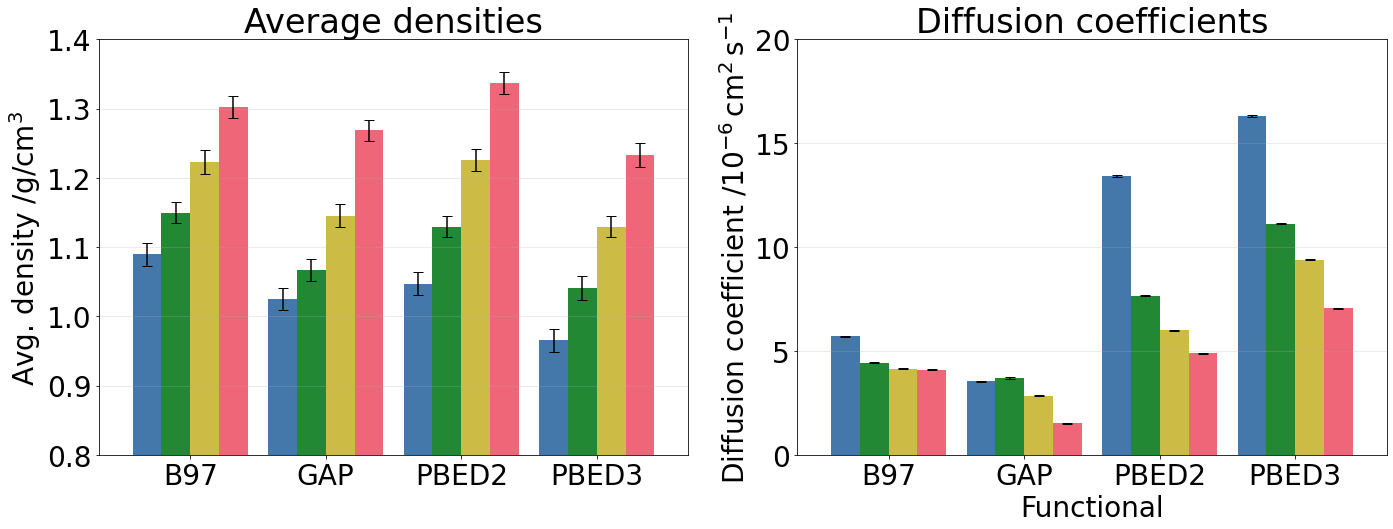

In [417]:
fsize = 28
plt.rcParams.update({'font.size': fsize})

order = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]


order = [
    'EMC',
    'EC:EMC (3:7)', 
    'EC:EMC (7:3)',
    'EC',
]

# Pivot tables for plotting
avg_pivot_df = plot_df.pivot(
	index='Functional',
	columns='Composition',
	values='Avg. density',
).sort_index(axis=0,ascending=True)[order]

std_pivot_df = plot_df.pivot(
	index='Functional',
	columns='Composition',
	values='Std. density',
).sort_index(axis=0,ascending=True)[order]

diff_pivot_df = plot_df.pivot(
	index='Functional',
	columns='Composition',
	values='Diffusion coefficient',
).sort_index(axis=0,ascending=True)[order]

differr_pivot_df = df.pivot(
	index='Functional',
	columns='Composition',
	values='Diff. fit error',
).sort_index(axis=0,ascending=True)[order]


fig, axs = plt.subplots(1,2, figsize=(10*2, 8*1), sharex=True, sharey=False)

axs[0].set_title('Average densities')
a0 = avg_pivot_df.plot.bar(
    ylim=[0.8,1.4],
    xlabel='',
    ylabel=f'Avg. density /{dunit}',
	yerr=std_pivot_df,
    capsize=5,
    rot=0,
    width=0.85,
    color=[get_colour(o) for o in order],
    ax=axs[0],
    legend=False,
)

axs[0].grid(axis='y', alpha=0.3)

axs[1].set_title('Diffusion coefficients')
a1 = diff_pivot_df.plot.bar(
    ylim=[0,20],
    ylabel=f'Diffusion coefficient /$10^{{-6}}\\,\\text{{cm}}^2\\,\\text{{s}}^{{-1}}$',
	yerr=differr_pivot_df,
    capsize=5,
    rot=0,
    width=0.85,
    color=[get_colour(o) for o in order],
    ax=axs[1],
    legend=False,
)
#for c0,c1 in zip(a0.containers, a1.containers):
#    axs[0,-1].bar_label(c0, rotation=90, fontsize=fsize-4, label_type='edge', fmt='%.3f', padding=10)
#    axs[1,-1].bar_label(c1, rotation=90, fontsize=fsize-4, label_type='edge', fmt='%.3f', padding=10)
"""
for i, (c0,c1) in enumerate(zip(a0.containers, a1.containers)):
    col_name = avg_pivot_df.columns[i]
    dens_vals = avg_pivot_df[col_name]
    dens_errs = std_pivot_df[col_name]
    dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]

    diff_vals = diff_pivot_df[col_name]
    diff_errors = differr_pivot_df[col_name]
    diff_labels = [f'{v:.2f} $\\pm$ {e:.2f}' for v, e in zip(diff_vals, diff_errors)]

    axs[0,-1].bar_label(c0, rotation=90, fontsize=fsize-5, label_type='center', padding=10, labels=dens_labels, color='white', weight='bold')
    axs[1,-1].bar_label(c1, rotation=90, fontsize=fsize-5, label_type='center', padding=10, labels=diff_labels, color='white', weight='bold')
    #axs[1,-1].bar_label(c1, rotation=90, fontsize=fsize-6, label_type='center', fmt='%.3f', padding=10, color='white')
"""

axs[1].grid(axis='y', alpha=0.3)

#axs[0, 1].set(yticklabels=[]); axs[0, 2].set(yticklabels=[]); axs[0, 3].set(yticklabels=[])
#axs[1, 1].set(yticklabels=[]); axs[1, 2].set(yticklabels=[])

#plt.rcParams.update({'font.size': 16})
plt.tight_layout()

#### Diffusion corrections
For the diffusion data, we first need to compute the correction coefficients used by [Schrodinger SI, equ 5](https://pubs.acs.org/doi/suppl/10.1021/acs.jpcb.2c03746/suppl_file/jp2c03746_si_001.pdf) and [Bamboo, equ 61](https://arxiv.org/pdf/2404.07181), quoting [standard practice, equ 3](https://livecomsjournal.org/index.php/livecoms/article/view/v1i1e6324/937).
$$
D(\infty)=D(L)+\frac{2.837298\times k_BT}{6\pi \eta L}
$$
Box sizes are computed from number of molecules (table S1) and densities (table S2) from Schrodinger, temperatures are taken from table S1 and viscosity from table S3.

<!---
The Arrhenius model of mixing states that the viscosity, $\eta$, of a liquid mixture is
$$
\ln\eta_\text{mix} = \sum_{i=0}^N x_i \ln \eta_i
$$
where $N$ is the number of components and $x_i$ is the mole fraction associated with component $i$.

Based on: https://www.frontiersin.org/journals/energy-research/articles/10.3389/fenrg.2022.1074699/full, the expected error associated with a binary mixture of hydrocarbons is around 5%, with a standard deviation of 6% of that. Thus the mixtures should carry an additional 0.3% uncertainty.
-->

Obtain sample masses:

In [726]:
mass_thermo = get_all_thermo(f'{dynamics_path}{tags[-1]}/*', xyz=True) # Argument should be 'tag' to be consistent with zenodo

for comp, traj in mass_thermo.items():
    if '000conEC' in comp:
        print('EMC:')
        M_EMC = traj[0].get_masses().sum() # g/mol
        m_EMC = M_EMC/ase.units.mol*1e-3 # kg
        print(f'Sample mass:\t{m_EMC} kg')
    elif '100conEC' in comp:
        print('EC:')
        M_EC = traj[0].get_masses().sum() # g/mol
        m_EC = M_EC/ase.units.mol*1e-3 # kg
        print(f'Sample mass:\t{m_EC} kg')

EMC:
Sample mass:	1.1582317925845882e-23 kg
EC:
Sample mass:	1.462303889780969e-23 kg


Obtain and apply correction:

In [741]:
import ase.units

corr_df = plot_df.copy()
corr_df = corr_df.drop('Train data', axis=1)
corr_df = corr_df.drop('log-log r2', axis=1)
corr_df = corr_df.drop('Diff. r2', axis=1) 
corr_df = corr_df.drop('Diff. start time /ns', axis=1)
corr_df = corr_df[(corr_df['Composition'] == 'EMC') | (corr_df['Composition'] == 'EC')]
corr_df

eta_EC = 1.9e-3 # Pa s
eta_EMC = 0.65e-3 # Pa s
kB = ase.units.kB/ase.units.J
xi = 2.837298
print(f'EMC viscosity:\t{eta_EMC} Pa s (at 298 K)')
print(f'EC viscosity:\t{eta_EC} Pa s (at 313 K)\n')

for tag, data in thermo.items():
    print(tag)
    data_set, functional, seed, dset = tag.split('/')
    for comp, traj in data.items():
        temp = int(comp.split('_')[-1][:-1])
        if '300K' in comp:
            dens = traj['v_mdensity']['data'].mean()*1000 # kg/m3
        else:
            dens = traj['Density']['data'].mean()*1000 # kg/m3
        if '000conEC' in comp:
            print('EMC:')
            volume = m_EMC/dens # m3
            L = volume**(1/3) # m
            corr = xi*kB*temp/(6*np.pi*eta_EMC*L) # kT=[J]=[Pa m3] => Pa m3/(Pa s m)=m2/s

        elif '100conEC' in comp:
            print('EC:')
            volume = m_EC/dens # m3
            L = volume**(1/3) # m
            corr = xi*kB*temp/(6*np.pi*eta_EMC*L) # kT=[J]=[Pa m3] => Pa m3/(Pa s m)=m2/s
        else:
            corr = 0
        
        corr *= 1e10 # 1e-6 cm2/s
        if corr > 0:
            print(f'Box length:\t{L*1e10:.3f} Å')
            print(f'Correction:\t{corr:.3f} 1e-6cm2/s\n')

        func_mask = corr_df['Functional'] == functional
        comp_mask = corr_df['Composition'] == tmap[comp]        
        corr_df.loc[func_mask & comp_mask, 'Diffusion coefficient'] += corr
corr_df

EMC viscosity:	0.00065 Pa s (at 298 K)
EC viscosity:	0.0019 Pa s (at 313 K)

IBM23/GAP/SEED1/DSET1
EMC:
Box length:	22.437 Å
Correction:	4.275 1e-6cm2/s

EC:
Box length:	22.591 Å
Correction:	4.246 1e-6cm2/s

IBM23/PBED3/SEED1/DSET1
EMC:
Box length:	22.895 Å
Correction:	4.161 1e-6cm2/s

EC:
Box length:	22.805 Å
Correction:	4.388 1e-6cm2/s

IBM23/PBED2/SEED1/DSET1
EMC:
Box length:	22.281 Å
Correction:	4.276 1e-6cm2/s

EC:
Box length:	22.197 Å
Correction:	4.508 1e-6cm2/s

IBM23/B97/SEED1/DSET1
EMC:
Box length:	21.988 Å
Correction:	4.333 1e-6cm2/s

EC:
Box length:	22.391 Å
Correction:	4.469 1e-6cm2/s



,Functional,Composition,Temperature,Avg. density,Std. density,Diffusion coefficient,Diff. fit error
0,GAP,EMC,300,1.025392,0.015684,7.804263,0.029709
3,GAP,EC,300,1.268290,0.014502,5.762579,0.021206
4,PBED3,EMC,298,0.965048,0.016399,20.477203,0.059591
7,PBED3,EC,313,1.232997,0.016728,11.437736,0.030697
8,PBED2,EMC,298,1.047056,0.016843,17.699447,0.058850
11,PBED2,EC,313,1.337139,0.015780,9.397591,0.014110
12,B97,EMC,298,1.089476,0.016971,10.041386,0.016936
15,B97,EC,313,1.302671,0.015686,8.573288,0.013205


Some latex output:

In [747]:
merged_df = corr_df.copy()
merged_df['Density'] = (
    merged_df['Avg. density'].map("{:.3f}".format) + " ± " + merged_df['Std. density'].map("{:.3f}".format)
)
merged_df['Diffusion coefficient'] = (
    merged_df['Diffusion coefficient'].map("{:.3f}".format) + " ± " + merged_df['Diff. fit error'].map("{:.3f}".format)
)
merged_df = merged_df.drop(['Avg. density', 'Std. density', 'Diff. fit error'], axis=1)

In [778]:
merged_df = corr_df.copy()
merged_df['Std. density'] *= 1000
merged_df['Diff. fit error'] *= 1000
merged_df['Density'] = (
    merged_df['Avg. density'].map("{:.3f}".format) + merged_df['Std. density'].map("({:.0f})".format)
)
merged_df['Diffusion coefficient'] = (
    merged_df['Diffusion coefficient'].map("{:.3f}".format) + merged_df['Diff. fit error'].map("({:.0f})".format)
)
merged_df = merged_df.drop(['Avg. density', 'Std. density', 'Diff. fit error'], axis=1)

In [779]:
cols = [
    'Composition',
    'Functional',
    'Temperature',
    'Density',
    'Diffusion coefficient'
]

dfs = []
for name, group in merged_df[cols].groupby('Composition'):
    dfs.append(group)

print(pd.concat(dfs).to_latex(index=False))

\begin{tabular}{lllll}
\toprule
Composition & Functional & Temperature & Density & Diffusion coefficient \\
\midrule
EC & GAP & 300 & 1.268(15) & 5.763(21) \\
EC & PBED3 & 313 & 1.233(17) & 11.438(31) \\
EC & PBED2 & 313 & 1.337(16) & 9.398(14) \\
EC & B97 & 313 & 1.303(16) & 8.573(13) \\
EMC & GAP & 300 & 1.025(16) & 7.804(30) \\
EMC & PBED3 & 298 & 0.965(16) & 20.477(60) \\
EMC & PBED2 & 298 & 1.047(17) & 17.699(59) \\
EMC & B97 & 298 & 1.089(17) & 10.041(17) \\
\bottomrule
\end{tabular}



# Intermolecular radial distributions

In [57]:
def get_mol_positions(atoms):
	positions = []
	mol_set = set(atoms.arrays['molID'])
	for ID in mol_set:
		mol = atoms[atoms.arrays['molID'] == ID]
		com = mol.get_center_of_mass()
		positions.append(com)
	positions = np.array(positions)
	return positions#, len(mol_set)

def mol_rdf(atoms, rmax, nbins, return_num_mols=False):
	positions = get_mol_positions(atoms)
	nmols, dim = positions.shape
	box_length = atoms.get_volume()**(1/3)
	for i, p in enumerate(positions):
		# PBC
		delta = positions[i+1:]-positions[i]
		delta -= box_length*np.round(delta/box_length)
		
		# Get counts
		dists = np.linalg.norm(delta, axis=1)
		s = sorted(dists[dists <= rmax])[1:]
		if i == 0:
			counts, bins = np.histogram(s, nbins, (0,rmax))
		else:
			counts += np.histogram(s, nbins, (0,rmax))[0]

	if return_num_mols:
		return counts, bins, nmols
	else:
		return counts, bins

def compute_rdf(traj, rmax=None, nbins=100, return_rho=False):
	for i, atoms in enumerate(traj):
		if i == 0:
			counts, bins, nmols = mol_rdf(atoms, rmax=rmax, nbins=nbins, return_num_mols=True)
			volume = atoms.get_volume()
			box_length = volume**(1/3)
			r = 0.5*(bins[1:]+bins[:-1])
		else:
			counts += mol_rdf(atoms, rmax=rmax, nbins=nbins)[0]
	
	num_snapshots = i+1
	nvalid = nmols/2
	n_k = counts/(nvalid*num_snapshots)	
	dr = rmax/nbins
	shell_volumes = 4/3*np.pi*((r+dr)**3-r**3)
	rho = nmols/volume
	
	g = n_k/(rho*shell_volumes)
	if return_rho:
		return g, r, rho
	else:
		return g, r

def get_indices_of_sign_change(lst):
    arr = np.array(lst)
    sign_changes = np.where(np.diff(np.sign(arr)) != 0)[0]
    #sign_changes = sign_changes[sign_changes>55] # The limit was taken from observation
    return sign_changes

In [ ]:
tags = [
    'IBM23/PBED3/SEED1/DSET1',
    'IBM23/PBED2/SEED1/DSET1',
    'IBM23/B97/SEED1/DSET1',
] # These tags needs to be adjusted to be compliant with zenodo

rdfs = {}
number_densities = {}
for tag in tags:
    data_set, functional, seed, dset_sample = tag.split('/')
    flist = [name for name in glob.glob(f'{dynamics_path}{tag}/*') if '.xyz' in name]
    print(f'{data_set}_{functional}')
    rdfs[f'{data_set}_{functional}'] = {}
    number_densities[f'{data_set}_{functional}'] = {}
    for file in flist:
        print(file)
        comp = file.split('/')[-1].split('.')[0][4:-5]
        comp = conmap[comp]
        traj = read(file, ':')
        aa.find_molecs(traj, fct=1.0)
        g, r, rho = compute_rdf(traj, rmax=11, return_rho=True)
        rdfs[f'{data_set}_{functional}'][comp] = [g, r]
        number_densities[f'{data_set}_{functional}'][comp] = rho
        del traj

with open('./part1_rdfs.pkl', 'wb') as f:
    pickle.dump(rdfs, f)

with open('./part1_rhos.pkl', 'wb') as f:
    pickle.dump(number_densities, f)

IBM23_PBED3
../publication/dynamics/IBM23/PBED3/SEED1/DSET1/npt_000conEC_298K.xyz
../publication/dynamics/IBM23/PBED3/SEED1/DSET1/npt_033conEC_298K.xyz
../publication/dynamics/IBM23/PBED3/SEED1/DSET1/npt_066conEC_298K.xyz
../publication/dynamics/IBM23/PBED3/SEED1/DSET1/npt_100conEC_313K.xyz
IBM23_PBED2
../publication/dynamics/IBM23/PBED2/SEED1/DSET1/npt_000conEC_298K.xyz
../publication/dynamics/IBM23/PBED2/SEED1/DSET1/npt_033conEC_298K.xyz
../publication/dynamics/IBM23/PBED2/SEED1/DSET1/npt_066conEC_298K.xyz
../publication/dynamics/IBM23/PBED2/SEED1/DSET1/npt_100conEC_313K.xyz
IBM23_B97
../publication/dynamics/IBM23/B97/SEED1/DSET1/npt_000conEC_298K.xyz
../publication/dynamics/IBM23/B97/SEED1/DSET1/npt_033conEC_298K.xyz
../publication/dynamics/IBM23/B97/SEED1/DSET1/npt_066conEC_298K.xyz
../publication/dynamics/IBM23/B97/SEED1/DSET1/npt_100conEC_313K.xyz


In [ ]:
tags = [
    'IBM23/PBED3/SEED1/DSET1',
    'IBM23/PBED2/SEED1/DSET1',
    'IBM23/B97/SEED1/DSET1',
] # These tags needs to be adjusted to be compliant with zenodo

rdfs, number_densities = eval_rdfs(tags, dynamics_path)

with open('./part1_rdfs.pkl', 'wb') as f:
    pickle.dump(rdfs, f)

with open('./part1_rhos.pkl', 'wb') as f:
    pickle.dump(number_densities, f)

IBM23_PBED3 DSET1 SEED1
../publication/dynamics/IBM23/PBED3/SEED1/DSET1/npt_000conEC_298K.xyz


In [781]:
with open('./part1_rdfs.pkl', 'rb') as f:
    rdfs = pickle.load(f)

with open('./part1_rhos.pkl', 'rb') as f:
    number_densities = pickle.load(f)

,Train data,Functional,Seed,Sample,Composition,Rmin,CN


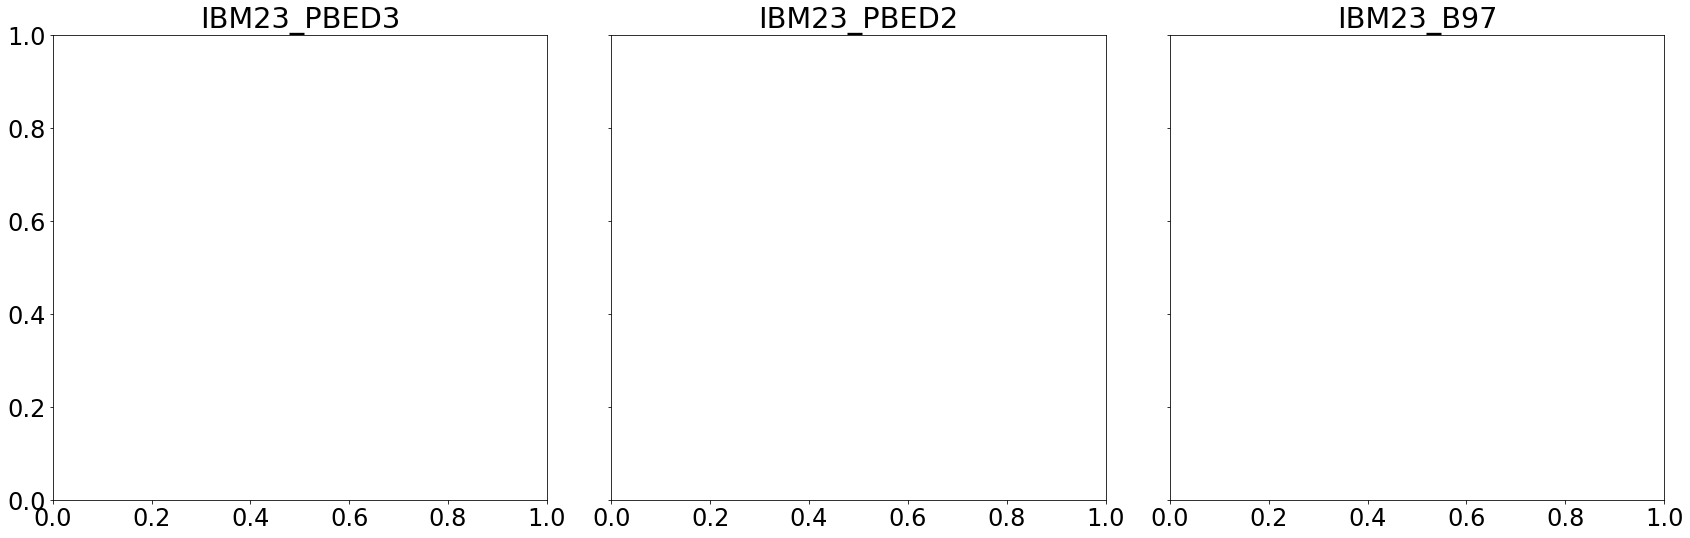

In [782]:
plt.rcParams.update({'font.size': fsize})


rstart = 6
id_width = 20

radii = []
fig, axs = plt.subplots(1,3, figsize=(3*8,1*8), sharey=True)
for ax, (model,dsets) in zip(axs, rdfs.items()):
    ax.set_title(model)
    #print(model)
    for dset,seeds in dsets.items():
        #print(dset)
        if dset == 'DSET1':
            for seed,comps in seeds.items():
                if seed == 'SEED1':
                    #print(seed)
                    for comp, (g, r) in comps.items():
                        #print(comp)
                        id0 = np.where(r>rstart)[0][0]
                        #print(id0, r[id0])
                        
                        idhi = id0+id_width
                        rmin = min(r[id0:idhi])
                        idx = np.argmin(g[id0:idhi])
                        #print(idx, r[idx])

                        ax.axvline(r[id0+idx], 0, 1, color=get_colour(comp), alpha=1, linestyle='dotted')
                        #ax.axvspan(r[id0], r[idhi],alpha=0.05, color='gray')
                        ax.plot(r, g, label=comp, color=get_colour(comp))
                        ax.legend(fontsize=fsize-8)
                        
                        rho = number_densities[model][dset][seed][comp]
                        r_prime = r[:id0+idx]
                        g_prime = g[1:id0+idx]                        
                        v_shell = 4/3*np.pi*(r_prime[1:]**3-r_prime[:-1]**3)
                        N = sum(g_prime*v_shell*rho)
                        
                        train_data, functional = model.split('_')
                        radii.append([train_data, functional, seed, dset, comp, r[id0+idx], N])
plt.tight_layout()

radii_df = pd.DataFrame(radii, columns=['Train data', 'Functional', 'Seed', 'Sample', 'Composition', 'Rmin', 'CN'])
for name, group in radii_df.groupby('Train data'):
    print('Average first shell coordinations:')
    print(name, group['CN'].mean(), '\n')
radii_df

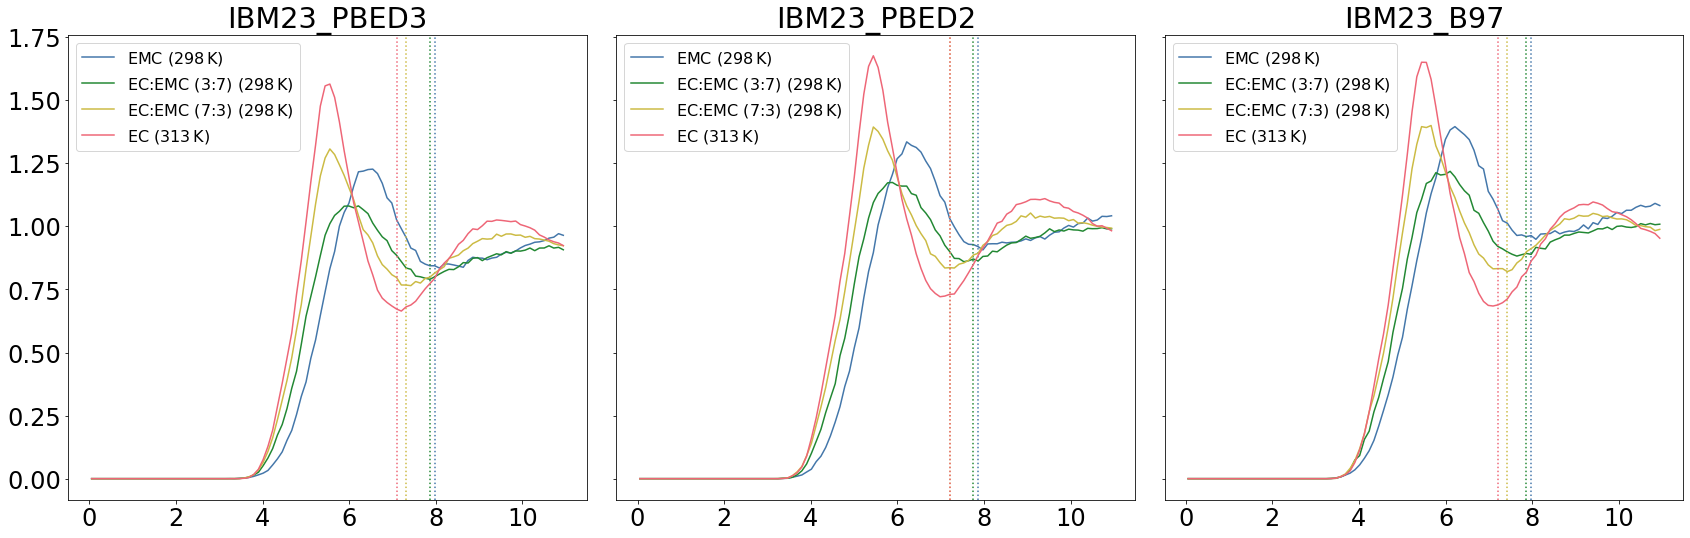

In [20]:
plt.rcParams.update({'font.size': fsize})

r0 = 6.5

fig, axs = plt.subplots(1,3, figsize=(3*8,1*8), sharey=True)
for ax, (model,comps) in zip(axs,rdfs.items()):
    ax.set_title(model)
    for comp, (g, r) in comps.items():
        id0 = np.where(r>r0)[0][0]
        dgdr = np.diff(g[r>r0]/r[r>r0])
        indices = get_indices_of_sign_change(dgdr)[0]
        idx = id0+indices
        ax.axvline(r[idx], 0, 1, color=get_colour(comp), alpha=1, linestyle='dotted')
        ax.plot(r, g, label=comp, color=get_colour(comp))
        ax.legend(fontsize=fsize-8)

plt.tight_layout()

IBM23_PBED3
EMC (298$\,$K)
9.009360718388569 

EC:EMC (3:7) (298$\,$K)
9.849819985769638 

EC:EMC (7:3) (298$\,$K)
9.013171272373054 

EC (313$\,$K)
9.83492572334144 

IBM23_PBED2
EMC (298$\,$K)
9.478238829518492 

EC:EMC (3:7) (298$\,$K)
10.303956249038906 

EC:EMC (7:3) (298$\,$K)
9.36414705201728 

EC (313$\,$K)
11.091834598837837 

IBM23_B97
EMC (298$\,$K)
10.386110306185193 

EC:EMC (3:7) (298$\,$K)
11.069858503258411 

EC:EMC (7:3) (298$\,$K)
10.285873352270675 

EC (313$\,$K)
10.851916880786318 



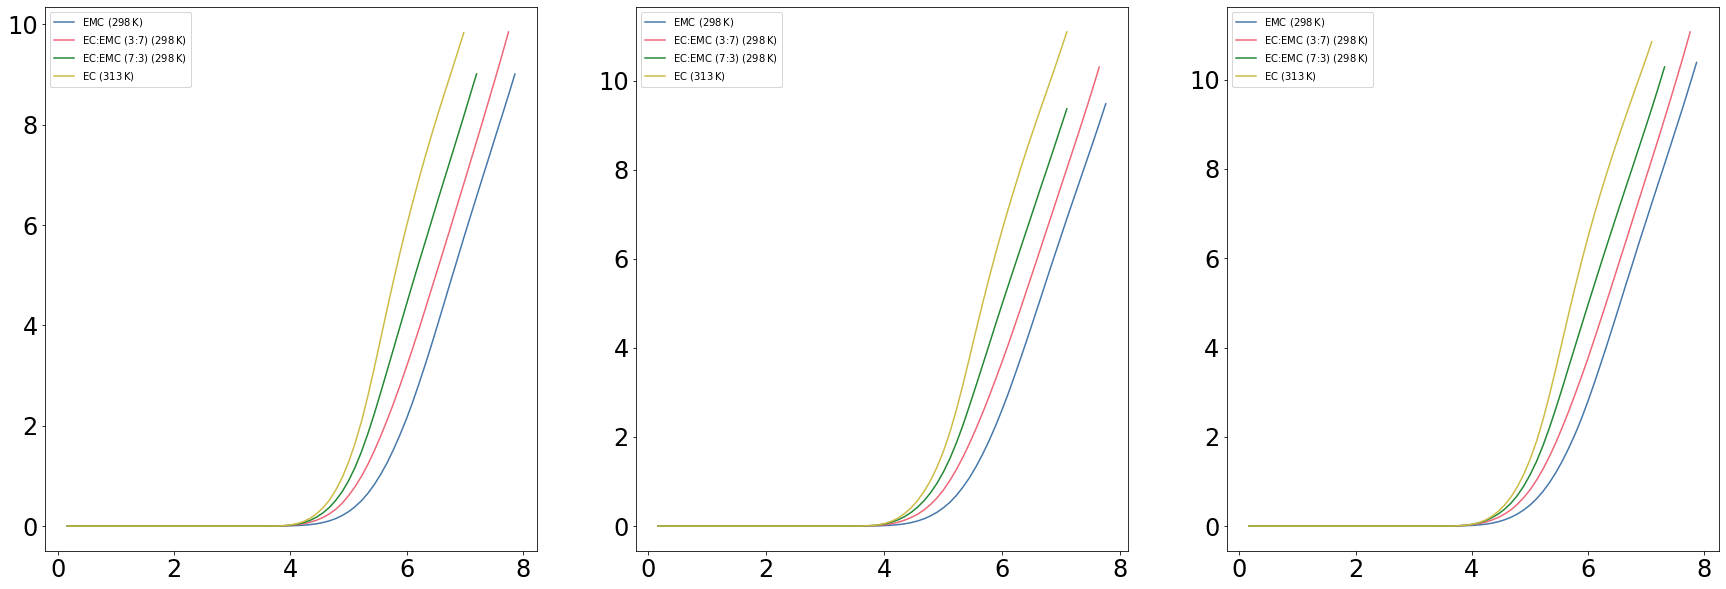

In [44]:
coordinations = {}
fig, axs = plt.subplots(1,3, figsize=(10*3, 10*1))
for ax, (model,comps) in zip(axs,rdfs.items()):
    print(model)
    coordinations[model] = {}
    for comp, (g, r) in comps.items():
        print(comp)
        rho = number_densities[model][comp]
        id0 = np.where(r>6.5)[0][0]
        dgdr = np.diff(g[r>6.5]/r[r>6.5])
        indices = get_indices_of_sign_change(dgdr)


        idx = id0+indices[0]
        g = g[1:idx]
        r = r[:idx]
        v_shell = 4/3*np.pi*(r[1:]**3-r[:-1]**3)
        N = g*v_shell*rho
        ax.plot(r[1:],np.cumsum(N), label=comp)
        
        ax.legend(fontsize=10)
        print(sum(N), '\n')
        coordinations[model][comp] = sum(N)

<Axes: >

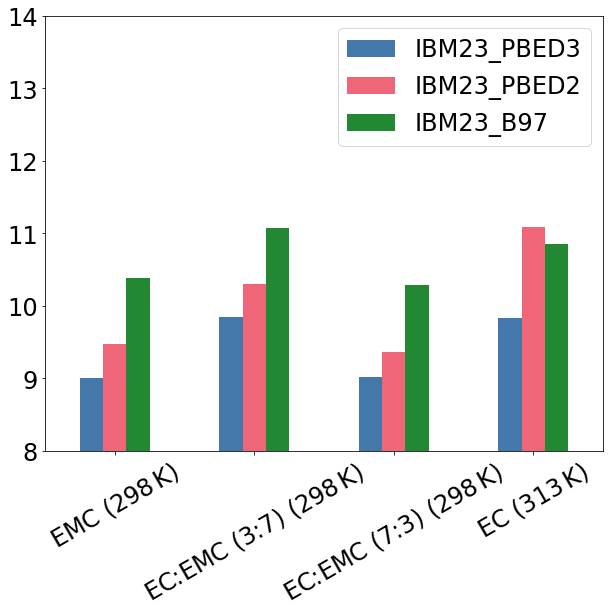

In [751]:
cn = pd.DataFrame.from_dict(coordinations)
cn.plot.bar(
    figsize=(10,8),
    ylim=(8,14),
    rot=30,
)

In [ ]:
cn = pd.DataFrame.from_dict(coordinations)
print('Average first shell cooridnations:')
cn.mean()


Average first shell cooridnations:


IBM23_PBED3     9.426819
IBM23_PBED2    10.059544
IBM23_B97      10.648440
dtype: float64

# Latex tables for paper

In [14]:
def functional_density(df, functional, composition):
    comp_mask = df['Composition'] == composition
    func_mask = df['Functional'] == functional
    selection = df[comp_mask & func_mask]['Avg. density']
    #return round(selection.iloc[0], precision)
    return selection.iloc[0]


configs = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

data = {
    'Functional pair':['\PBE{2} and \PBE{3}', '\PBE{2} and \BNS', '\PBE{3} and \BNS'],
}

for config in configs:
    PBED2_dens = functional_density(df, 'PBED2', config)
    PBED3_dens = functional_density(df, 'PBED3', config)
    B97D3_dens = functional_density(df, 'B97', config)
    data[config] = [abs(PBED2_dens-PBED3_dens),abs(PBED2_dens-B97D3_dens),abs(PBED3_dens-B97D3_dens)]
    print(config)
    print(f'PBED2-PBED3 diff.: {abs(PBED2_dens-PBED3_dens):.4f} g/mL')
    print(f'PBED2-B97D3 diff.: {abs(PBED2_dens-B97D3_dens):.4f} g/mL')
    print(f'PBED3-B97D3 diff.: {abs(PBED3_dens-B97D3_dens):.4f} g/mL\n')

dens_df = pd.DataFrame(data).round(decimals=3)
print(dens_df.to_latex(index=False))

EMC (298$\,$K)
PBED2-PBED3 diff.: 0.0820 g/mL
PBED2-B97D3 diff.: 0.0424 g/mL
PBED3-B97D3 diff.: 0.1244 g/mL

EC:EMC (3:7) (298$\,$K)
PBED2-PBED3 diff.: 0.0886 g/mL
PBED2-B97D3 diff.: 0.0204 g/mL
PBED3-B97D3 diff.: 0.1090 g/mL

EC:EMC (7:3) (298$\,$K)
PBED2-PBED3 diff.: 0.0960 g/mL
PBED2-B97D3 diff.: 0.0027 g/mL
PBED3-B97D3 diff.: 0.0933 g/mL

EC (313$\,$K)
PBED2-PBED3 diff.: 0.1041 g/mL
PBED2-B97D3 diff.: 0.0345 g/mL
PBED3-B97D3 diff.: 0.0697 g/mL

\begin{tabular}{lrrrr}
\toprule
Functional pair & EMC (298$\,$K) & EC:EMC (3:7) (298$\,$K) & EC:EMC (7:3) (298$\,$K) & EC (313$\,$K) \\
\midrule
\PBE{2} and \PBE{3} & 0.082000 & 0.089000 & 0.096000 & 0.104000 \\
\PBE{2} and \BNS & 0.042000 & 0.020000 & 0.003000 & 0.034000 \\
\PBE{3} and \BNS & 0.124000 & 0.109000 & 0.093000 & 0.070000 \\
\bottomrule
\end{tabular}



In [15]:
def functional_diffusivity(df, functional, composition):
    comp_mask = df['Composition'] == composition
    func_mask = df['Functional'] == functional
    selection = df[comp_mask & func_mask]['Diffusion coefficient']
    return selection.iloc[0]


configs = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

data = {
    'Functional pair':['\PBE{2} and \PBE{3}', '\PBE{2} and \BNS', '\PBE{3} and \BNS'],
}

for config in configs:
    PBED2_diff = functional_diffusivity(df, 'PBED2', config)
    PBED3_diff = functional_diffusivity(df, 'PBED3', config)
    B97D3_diff = functional_diffusivity(df, 'B97', config)
    data[config] = [abs(PBED2_diff-PBED3_diff),abs(PBED2_diff-B97D3_diff),abs(PBED3_diff-B97D3_diff)]
    print(config)
    print(f'PBED2-PBED3 diff.: {abs(PBED2_diff-PBED3_diff):.4f}*1e-6 cm2/s')
    print(f'PBED2-B97D3 diff.: {abs(PBED2_diff-B97D3_diff):.4f}*1e-6 cm2/s')
    print(f'PBED3-B97D3 diff.: {abs(PBED3_diff-B97D3_diff):.4f}*1e-6 cm2/s\n')

diff_df = pd.DataFrame(data).round(decimals=4)
print(diff_df.to_latex(index=False))

EMC (298$\,$K)
PBED2-PBED3 diff.: 3.0357*1e-6 cm2/s
PBED2-B97D3 diff.: 8.1350*1e-6 cm2/s
PBED3-B97D3 diff.: 11.1707*1e-6 cm2/s

EC:EMC (3:7) (298$\,$K)
PBED2-PBED3 diff.: 3.7300*1e-6 cm2/s
PBED2-B97D3 diff.: 3.2143*1e-6 cm2/s
PBED3-B97D3 diff.: 6.9444*1e-6 cm2/s

EC:EMC (7:3) (298$\,$K)
PBED2-PBED3 diff.: 3.3941*1e-6 cm2/s
PBED2-B97D3 diff.: 2.0135*1e-6 cm2/s
PBED3-B97D3 diff.: 5.4076*1e-6 cm2/s

EC (313$\,$K)
PBED2-PBED3 diff.: 2.0895*1e-6 cm2/s
PBED2-B97D3 diff.: 0.8269*1e-6 cm2/s
PBED3-B97D3 diff.: 2.9165*1e-6 cm2/s

\begin{tabular}{lrrrr}
\toprule
Functional pair & EMC (298$\,$K) & EC:EMC (3:7) (298$\,$K) & EC:EMC (7:3) (298$\,$K) & EC (313$\,$K) \\
\midrule
\PBE{2} and \PBE{3} & 3.035700 & 3.730000 & 3.394100 & 2.089500 \\
\PBE{2} and \BNS & 8.135000 & 3.214300 & 2.013500 & 0.826900 \\
\PBE{3} and \BNS & 11.170700 & 6.944400 & 5.407600 & 2.916500 \\
\bottomrule
\end{tabular}

